# Keras教程 

欢迎来到第2周的作业1。在此作业中，你将：
1. 学习使用Keras，这是一种高级神经网络API（编程框架），采用Python编写，并且能够在包括TensorFlow和CNTK在内的几个较低级框架之上运行。
1. 了解如何在几个小时内构建深度学习算法。

我们为什么要使用Keras？开发Keras的目的是使深度学习工程师能够快速构建和试验不同的模型。正如TensorFlow是一个比Python更高级的框架一样，Keras是一个甚至更高层次的框架，能够以最小的延迟将想法付诸实践是找到良好模型的关键。但是，Keras比低级框架更具限制性，因此可以在TensorFlow中实现一些非常复杂的模型，而在Keras中实现这些模型较为困难。话虽如此，Keras仍可以在许多常见模型上正常工作。

在本练习中，你将解决“the Happy House”问题，我们将在下面进行解释。首先让我们加载所需的软件包并开始解决问题吧！

In [1]:
cd ../data/L4W2KT

G:\deep learning\deeplearning.ai\data\L4W2KT


In [2]:
import numpy as np
#import tensorflow as tf
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

Using TensorFlow backend.


**注意**：如你所见，我们从Keras导入了许多函数。 你可以在笔记本中直接调用它们；
例如：`X = Input（...）`或`X = ZeroPadding2D（...）`。

## 1 The Happy House 挑战 

你决定与五个朋友在下个假期一起度过一星期。你们来到一个非常方便的房子，附近有很多事情可以做。但是最重要的好处是，每个人在家里时都承诺要快乐。因此，任何想要进入房屋的人都必须证明自己目前的幸福状态。
作为一名深度学习专家，要确保严格执行“Happy”规则，你将要构建一种算法，该算法使用前门摄像头中的图片来检查该人是否快乐。仅当该人感到高兴时，门才应打开。

你已经通过前门摄像头收集了你的朋友和你自己的照片。数据集是附带标签的。

![Image](../image/L4W2KT/1.png)

运行以下代码以标准化数据集并查看其维度。

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


**数据集的详细信息**：
- 图像维度（64、64、3）
- 训练：600张图片
- 测试：150张图片

现在该解决“Happy”挑战了。

## 2 在Keras中建立模型

Keras非常适合快速制作原型，你可以在很短的时间内，建立一个能够获得出色结果的模型。

这是Keras中的模型构建示例：

```python
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model
```

请注意，Keras使用变量名与我们之前使用numpy和TensorFlow不同。不是在正向传播的每个步骤上创建和分配新变量，例如`X`, `Z1`, `A1`, `Z2`, `A2`等，以用于不同层的计算， Keras代码上面的每一行只是使用`X = ...`将`X`重新分配给新值。换句话说，在正向传播的每个步骤中，我们只是将计算中的最新值写入相同的变量`X`。唯一的例外是`X_input`，我们将其分开并没有覆盖，因为我们最终需要它来创建Keras模型实例（上面的`model = Model(inputs = X_input, ...)`）。

**练习**：实现一个`HappyModel（）`。我们建议你首先使用我们建议的结构来实现模型，然后再使用该模型作为初始模型来完成本任务的其余部分。之后请返回并主动尝试其他模型架构。例如，你可能会从上面的模型中获得启发，但是随后根据需要更改网络体系结构和超参数。你还可以使用其他函数，例如`AveragePooling2D()`, `GlobalMaxPooling2D()`, `Dropout()`。

**注意**：注意数据的维度。利用你在视频中学到的知识，确保卷积，池化和全连接层适用。

In [4]:
# GRADED FUNCTION: HappyModel

def HappyModel(input_shape):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    
    ### START CODE HERE ###
    # Feel free to use the suggested outline in the text above to get started, and run through the whole
    # exercise (including the later portions of this notebook) once. The come back also try out other
    # network architectures as well. 
    X_input = Input(shape=input_shape)
    X = ZeroPadding2D(padding=(1, 1))(X_input)
    X = Conv2D(8, kernel_size=(3,3), strides=(1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(X)
    
    X = ZeroPadding2D(padding=(1, 1))(X)
    X = Conv2D(16, kernel_size=(3,3), strides=(1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(X)
    
    X = ZeroPadding2D(padding=(1, 1))(X)
    X = Conv2D(32, kernel_size=(3,3), strides=(1,1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(X)
    
    # FC
    X = Flatten()(X)
    Y = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs = X_input, outputs = Y, name='HappyModel')
    ### END CODE HERE ###
    
    return model

现在，你已经构建了一个描述模型的函数。为了训练和测试该模型，Keras中有四个步骤：

1. 通过调用上面的函数创建模型
1. 通过调用`model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`编译模型
1. 通过调用`model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`训练模型
1. 通过调用`model.evaluate(x = ..., y = ...)`测试模型

如果你想进一步了解`model.compile（）`，`model.fit（）`，`model.evaluate（）`及其参数，请参考官方 [Keras documentation](https://keras.io/models/model/)

**练习**：第一步，创建模型

In [5]:
### START CODE HERE ### (1 line)
happyModel = HappyModel((64, 64, 3))
### END CODE HERE ###

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



**练习**：实施第2步，编译模型以配置学习过程。 正确选择 `compile()`的3个参数。
提示：“快乐挑战”是一个二进制分类问题。

In [6]:
### START CODE HERE ### (1 line)
import keras
happyModel.compile(optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss='binary_crossentropy', metrics=['accuracy'])
### END CODE HERE ###

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**练习**：实施第3步，训练模型。选择epoch和批次大小。

In [7]:
### START CODE HERE ### (1 line)
happyModel.fit(x=X_train, y=Y_train, batch_size=16, epochs=20)
### END CODE HERE ###


Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.5557 - accuracy: 0.7267
Epoch 2/20
600/600 [==============================] - 0s 597us/step - loss: 0.2176 - accuracy: 0.9400
Epoch 3/20
600/600 [==============================] - 0s 592us/step - loss: 0.1420 - accuracy: 0.9683
Epoch 4/20
600/600 [==============================] - 0s 605us/step - loss: 0.1076 - accuracy: 0.9767
Epoch 5/20
600/600 [==============================] - 0s 596us/step - loss: 0.0857 - accuracy: 0.9833
Epoch 6/20
600/600 [==============================] - 0s 584us/step - loss: 0.0785 - accuracy: 0.9767
Epoch 7/20
600/600 [==============================] - 0s 572us/step - loss: 0.0531 - accuracy: 0.9917
Epoch 8/20
600/600 [==============================] - 0s 588us/step - loss: 0.0435 - accuracy: 0.9933
Epoch 9/20
600/600 [==============================] - 0s 570us/step - loss: 0.0339 - accuracy: 0.9950
Epoch 10/20
600/600 [==============================] - 0s 592us/step - loss: 0.0336

请注意，如果再次运行`fit()`，`model`将继续使用已经学习的参数进行训练，而不是重新初始化它们。

**练习**：实施第4步，测试/评估模型。

In [8]:
### START CODE HERE ### (1 line)
preds = happyModel.evaluate(x=X_test, y=Y_test)
### END CODE HERE ###
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 0s 3ms/step

Loss = 0.0925657457113266
Test Accuracy = 0.9733333587646484


如果你的`happyModel()`函数起作用，在训练和测试集上的测试结果应该比随机猜测（50％）更好。要通过此作业，你必须至少达到75％的准确性。

为了给你提供一个比较点，我们的模型在batch size为16个和adam优化器的情况下，在40个epoch内获得了95％的测试准确度（和99％的训练准确度）。但是我们的模型仅需2-5个epoch即可获得不错的准确性，因此，如果你要比较不同的模型，则还可以在几个epoch上训练各种模型，并观察比较它们。

如果你尚未达到75％的准确度，可以尝试以下方法来达到此目的：

- 尝试使用CONV-> BATCHNORM-> RELU模块，例如：
```python
X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X)
X = BatchNormalization(axis = 3, name = 'bn0')(X)
X = Activation('relu')(X)
```
- 你可以在此模块之后使用MAXPOOL。这将帮助你降低高度和宽度尺寸。
- 更改优化器。我们发现Adam行之有效。
- 如果模型运行困难，并且遇到内存问题，请降低batch_size（例如12）
- 运行更多epoch，直到看到训练精度达到稳定。

即使你已达到75％的准确性，也可以调整模型，尝试获得更好的结果。

**注意**：如果你调整模型超参数，则测试集实际上将成为开发集，并且你的模型最终可能会过拟合测试（开发）集。但仅出于此作业的目的，我们在此无需担心。


## 3 结论

Nice，你已经解决了快乐之家的挑战！

现在，你只需要将此模型连接到房屋的前门摄像头即可。

**我们希望你从这项作业中记住什么：**
- Keras是我们建议用于快速制作模型的工具。它使你可以快速尝试不同的模型架构。你有想用Keras实现日常生活中任何深度学习的应用吗？
- 记住如何在Keras中编码模型以及完成在测试集上评估模型的四个步骤。创建->编译->调整/训练->评估/测试。

## 4 使用你自己的图像进行测试（可选）

祝贺你完成此作业。现在，你可以拍张照片，看看是否可以进入快乐之家。要做到这一点：
     1.单击此笔记本上部栏中的"File"，然后单击"Open"以在Coursera Hub上运行。
     2.将图像添加到Jupyter Notebook的目录中，在"images"文件夹中
     3.在以下代码中写下你的图片名称
     4.运行代码并检查算法是否正确（0表示unhappy，1表示happy）！
    
训练/测试集非常相似。例如，所有图片都是在相同背景下拍摄的（因为前门摄像头始终安装在同一位置）。这使问题变得更容易，但是根据该数据训练的模型也可能无法在你自己的数据上工作。但是，可以尝试一下！

[[1.]]


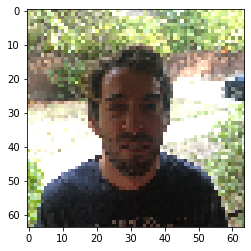

In [9]:
### START CODE HERE ###
img_path = 'my_image.jpg'
### END CODE HERE ###
img = image.load_img(img_path, target_size=(64, 64))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happyModel.predict(x))

## 5 Keras中的其他有用函数（可选）

你会发现Keras中其他两个有用的基本功能是：
- `model.summary()`：以表格形式打印每层输入输出的详细信息
- `plot_model()`：绘制图形，如果你想在社交媒体上共享它，可以使用SVG（）将其另存为“ .png”，它保存在笔记本计算机上方栏中的"File"然后"Open..." 中。

运行以下代码。

In [10]:
happyModel.summary()

Model: "HappyModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 66, 66, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 34, 34, 8)         0

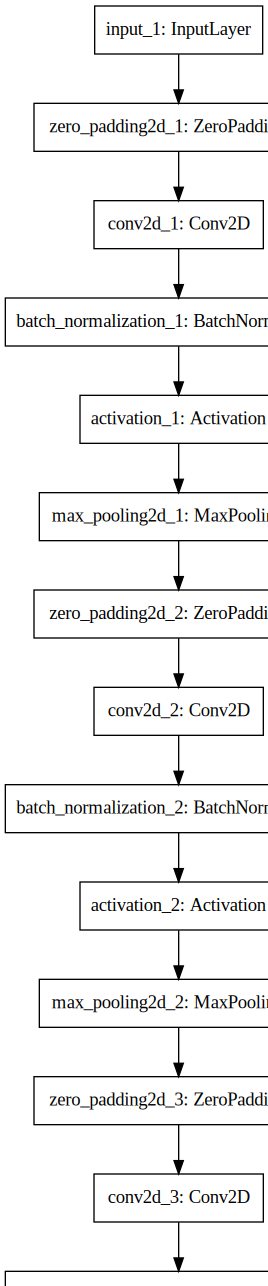

In [11]:
plot_model(happyModel, to_file='HappyModel.png')
SVG(model_to_dot(happyModel).create(prog='dot', format='svg'))